In this notebook
1) Get data \
    1.1) Read HDF5 \
    1.2) Select only I channel 
2) Filter with moving average
3) Cut data (discard baseline tale) 
4) Filter data (movinga average)
5) Compute second derivative
6) Get cuspid point on x-axis
7) Select 1/8 of total signal lenght for pre trigger

In [3]:
import h5py
import os
import sys
sys.path.append(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT')
from HDF5 import HDF5
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter, find_peaks
from scipy.optimize import curve_fit

In [4]:
def read(parent):
    data = []
    for root, dirs, files in os.walk(parent):
        for file in files:
            if file.endswith('.hdf5'):
                file_path = os.path.join(root, file)
                f = HDF5.HDF5()
                f.name = file_path
                data.append(f.load_hdf5()['Signals']['I'])
    return data


In [5]:
data = read(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\RUNS\1')

Execution time: 0.162
Execution time: 0.167
Execution time: 0.162
Execution time: 0.164
Execution time: 0.165
Execution time: 0.159
Execution time: 0.157
Execution time: 0.156
Execution time: 0.161
Execution time: 0.163


(xmin, ymin) = (200579,-0.027695648663211614)


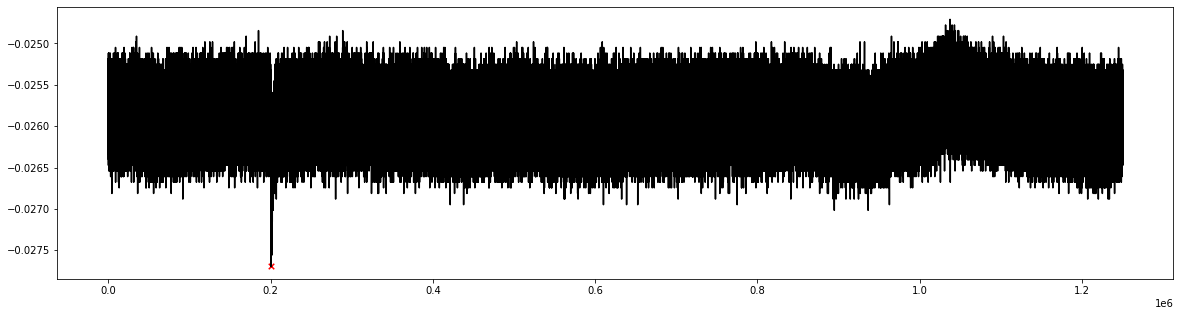

In [6]:
xmin, ymin = [np.argmin(data[1]) , min(data[1])]
plt.figure(figsize=(20,5))
plt.plot(np.linspace(0,len(data[1]),len(data[1])),data[1],color='black')
plt.scatter(xmin, ymin, marker='x',color='red',s=30)
print(f'(xmin, ymin) = ({xmin},{ymin})')

In [7]:
#idx = [i for i in range(len(data[1])) if (i<int(0.3*1e6) and i>int(0.15*1e6))]
#I = data[1][idx]

I = data[1][xmin-3000:xmin+10000]
T = np.linspace(xmin-3000,xmin+10000,len(I),dtype=int)

In [8]:
# Apply moving average filter
window_size = 50  # Size of the moving average window
cumsum = np.cumsum(I)
cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
moving_avg = cumsum[window_size - 1:] / window_size
# Pad the moving average to match the length of the original signal
moving_avg = np.pad(moving_avg, (window_size - 1, 0), mode='constant', constant_values=(moving_avg[0], moving_avg[-1]))

In [9]:
window_length = 171  # Must be odd
polyorder = 3
sg_filtered_signal = savgol_filter(moving_avg, window_length, polyorder)

# Post-processing: Optional further smoothing
window_size = 5
smoothed_signal = np.convolve(sg_filtered_signal, np.ones(window_size)/window_size, mode='valid')

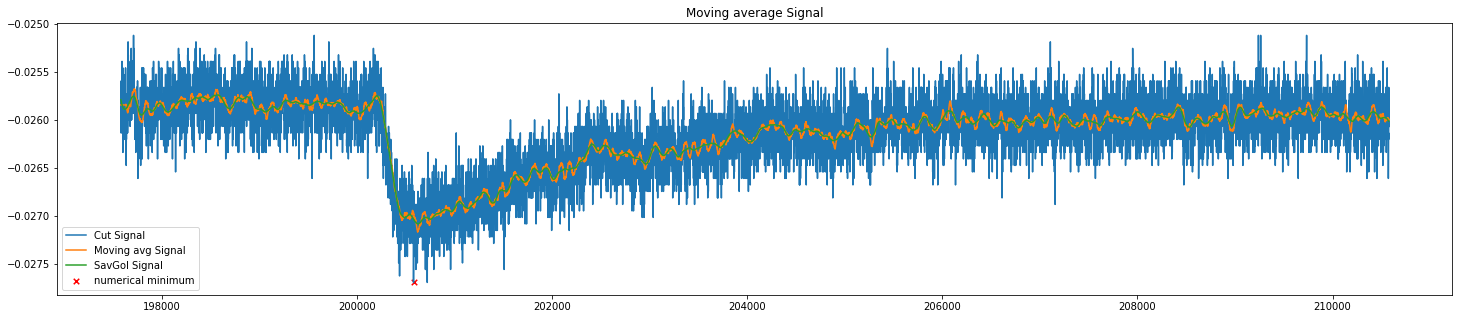

In [10]:
plt.figure(figsize=(25,5))
plt.plot(T, I, label='Cut Signal')
plt.plot(T, moving_avg, label='Moving avg Signal')
plt.plot(T[:len(smoothed_signal)], smoothed_signal, label='SavGol Signal')
plt.scatter(xmin, ymin, marker='x',color='red',s=30,label='numerical minimum')
plt.title('Moving average Signal')
plt.legend()

In [111]:
len_fit = int(np.floor(len(I)/10))
pol_amp = np.polyfit(T[:len_fit], I[:len_fit], 2)
rms = np.sqrt(np.mean((np.polyval(pol_amp, T[:len_fit])-I[:len_fit])**2))   

In [109]:
def model(x, A,B,C,D):
    return A*np.exp(-B*(x-C))+D

def sigmoid(x, A, B, C, D):
    return A / (1.0 + np.exp(-B * (x - C))) + D

In [110]:
p0 = [14,0.00046,180322,0.0259]
p0_sig = [0.0012,0.1,200300,0.0258]

In [112]:
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [120]:
sig = LeastSquares(T[2000:3200],-smoothed_signal[2000:3200],rms,sigmoid)
exp = LeastSquares(T[3000:len(smoothed_signal)],-smoothed_signal[3000:len(smoothed_signal)],rms,model)
msig = Minuit(sig,*p0_sig)
mexp = Minuit(exp,*p0)
msig.migrad(iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 48.03 (χ²/ndof = 0.0)      │              Nfcn = 121              │
│ EDM = 5.44e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │ 1.187e-3  │ 0.016e-3  │            │            │         │         │       │
│ 1 │ B    │  0.0282   │  0.0019   │            │            │         │         │       │
│ 2 │ C    │200.3470e3 │ 0.0032e3  │            │            │         │         │       │
│ 3 │ D    │ 25.847e-3 │ 0.009e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────────┐
│   │          A          B          C          D │
├───┼─────────────────────────────────────────────┤
│ A │   2.54e-10  -11.99e-9 9.57406e-6   -0.08e-9 │
│ B │  -11.99e-9   3.69e-06    -875e-6    3.45e-9 │
│ C │ 9.57406e-6    -875e-6       9.95 6.39428e-6 │
│ D │   -0.08e-9    3.45e-9 6.39428e-6   7.81e-11 │
└───┴─────────────────────────────────────────────┘

In [121]:
mexp.migrad(iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 549.7 (χ²/ndof = 0.1)      │              Nfcn = 115              │
│ EDM = 2.87e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   14.1    │    1.1    │            │            │         │         │       │
│ 1 │ B    │ 464.0e-6  │  3.4e-6   │            │            │         │         │       │
│ 2 │ C    │ 180.34e3  │  0.17e3   │            │            │         │         │       │
│ 3 │ D    │25.9386e-3 │ 0.0033e-3 │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────────────────────┐
│   │             A             B             C             D │
├───┼─────────────────────────────────────────────────────────┤
│ A │           1.2   1.659009e-6        -110.0    626.870e-9 │
│ B │   1.659009e-6      1.16e-11 259.389840e-6      0.005e-9 │
│ C │        -110.0 259.389840e-6      2.85e+04  98.012133e-6 │
│ D │    626.870e-9      0.005e-9  98.012133e-6       1.1e-11 │
└───┴─────────────────────────────────────────────────────────┘

Text(0.5, 1.0, 'Time constant FIT')

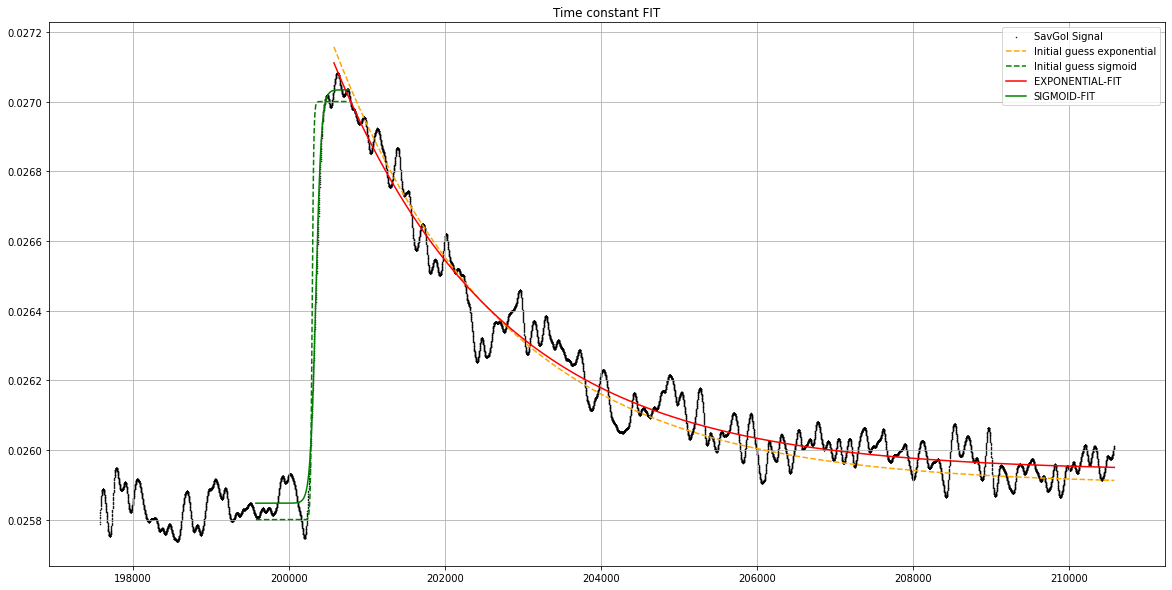

In [122]:
plt.figure(figsize=(20,10))
plt.scatter(T[:len(smoothed_signal)], -smoothed_signal, label='SavGol Signal',marker='.',s=1,color='black')
plt.plot(T[3000:13000],model(T[3000:13000],*p0),label='Initial guess exponential',linestyle='--',color='orange')
plt.plot(T[2000:3200],sigmoid(T[2000:3200],*p0_sig),label='Initial guess sigmoid',linestyle='--',color='green')
plt.plot(T[3000:13000],model(T[3000:13000],*mexp.values),label='EXPONENTIAL-FIT',linestyle='-',color='red')
plt.plot(T[2000:3200],sigmoid(T[2000:3200],*msig.values),label='SIGMOID-FIT',linestyle='-',color='green')
plt.legend()
plt.grid()
plt.title('Time constant FIT')

In [126]:
mexp.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,A,14.1,1.1,,,,,
1,B,464.0e-6,3.4e-6,,,,,
2,C,180.34e3,0.17e3,,,,,
3,D,25.9386e-3,0.0033e-3,,,,,


In [127]:
msig.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,A,1.187e-3,0.016e-3,,,,,
1,B,0.0282,0.0019,,,,,
2,C,200.3470e3,0.0032e3,,,,,
3,D,25.847e-3,0.009e-3,,,,,


In [135]:
# Calculate the 10% and 90% points of the fitted signal
y_10 = msig.values['D'] + 0.1 * msig.values['A']
y_90 = msig.values['D'] + 0.9 * msig.values['A']

# Find the time at which the signal reaches these values
t_10 = T[np.abs(sigmoid(T[2000:3200],*msig.values) - y_10).argmin()]
t_90 = T[np.abs(sigmoid(T[2000:3200],*msig.values) - y_90).argmin()]

# Calculate the rise time
rise_time = (t_90 - t_10)*1e-8
print(f"Rise Time: {rise_time*1e6:.4f} micro seconds")

Rise Time: 1.5600 micro seconds


In [320]:
window = 11 
polyorder = 3 
fd = savgol_filter(I,window, polyorder, deriv=1) 
sd = savgol_filter(I,window, polyorder, deriv=2) 

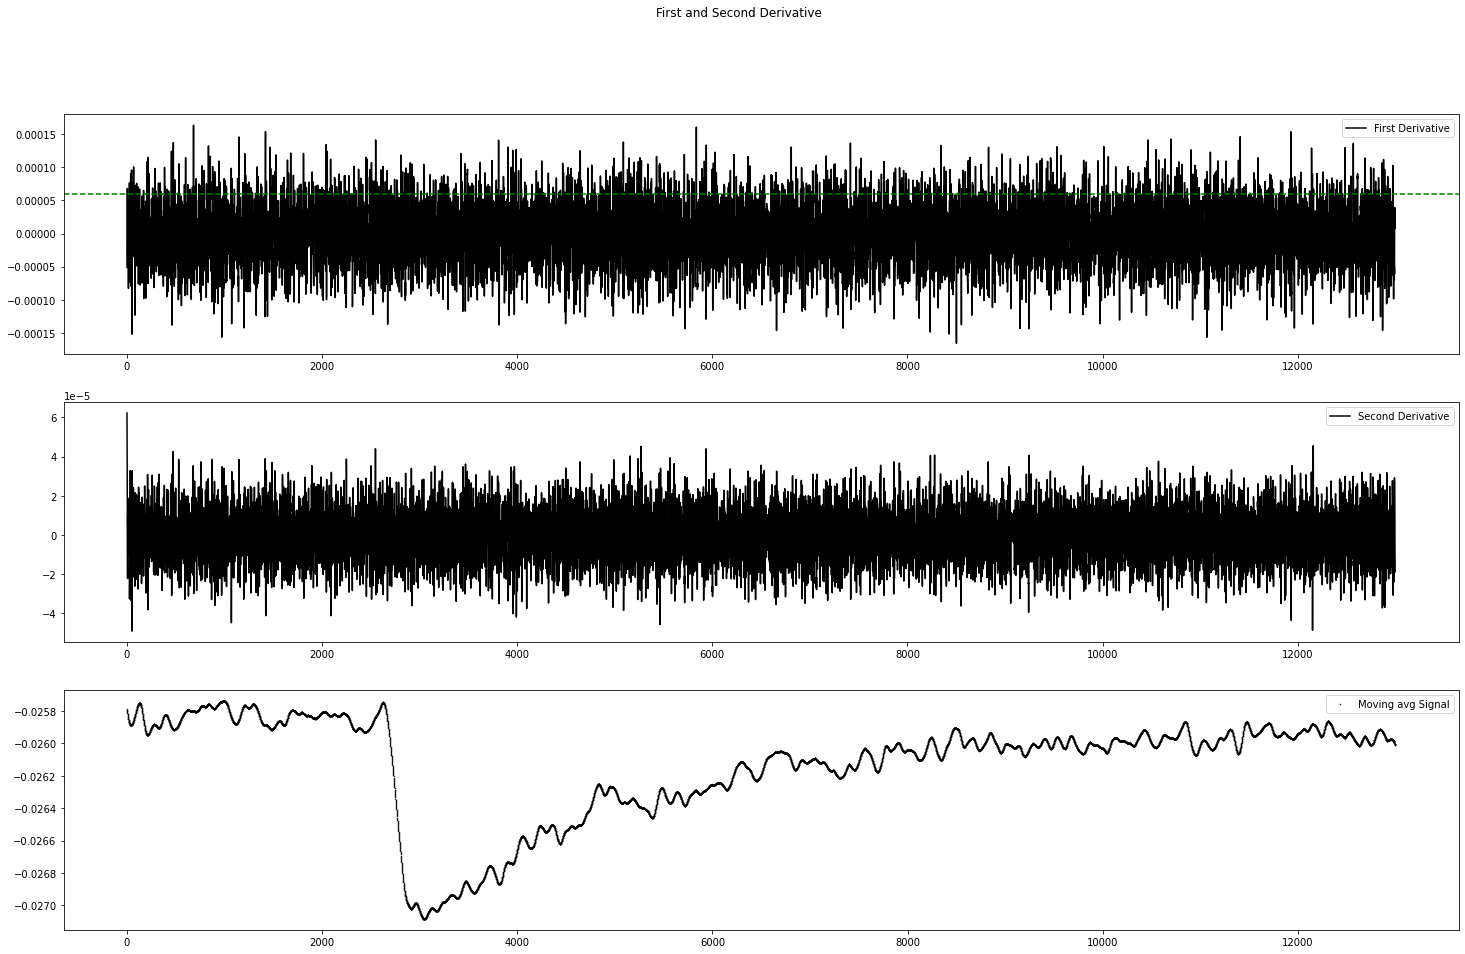

In [325]:
th = 6*1e-5
peaks, props = find_peaks(sd, th,)
fig, axs = plt.subplots(3,1,figsize=(25,15))
axs[1].plot(np.linspace(0,len(sd),len(sd)),sd,color='black',label='Second Derivative')
axs[0].plot(np.linspace(0,len(fd),len(fd)),fd,color='black',label='First Derivative')
#axs[0].axhline(th, 0, 1, linestyle='--', color='green')
axs[2].scatter(np.linspace(0,len(smoothed_signal),len(smoothed_signal)), smoothed_signal, label='Moving avg Signal',marker='.',color='black',s=1)
axs[0].scatter(peaks, props['peak_heights'], marker='x', color='red', s=10)
axs[2].scatter(peaks, smoothed_signal[peaks], marker='x', color='red', s=10)
axs[0].axhline(th, 0, 1, linestyle='--', color='green')
fig.suptitle('First and Second Derivative')
axs[0].legend()
axs[1].legend()
axs[2].legend()

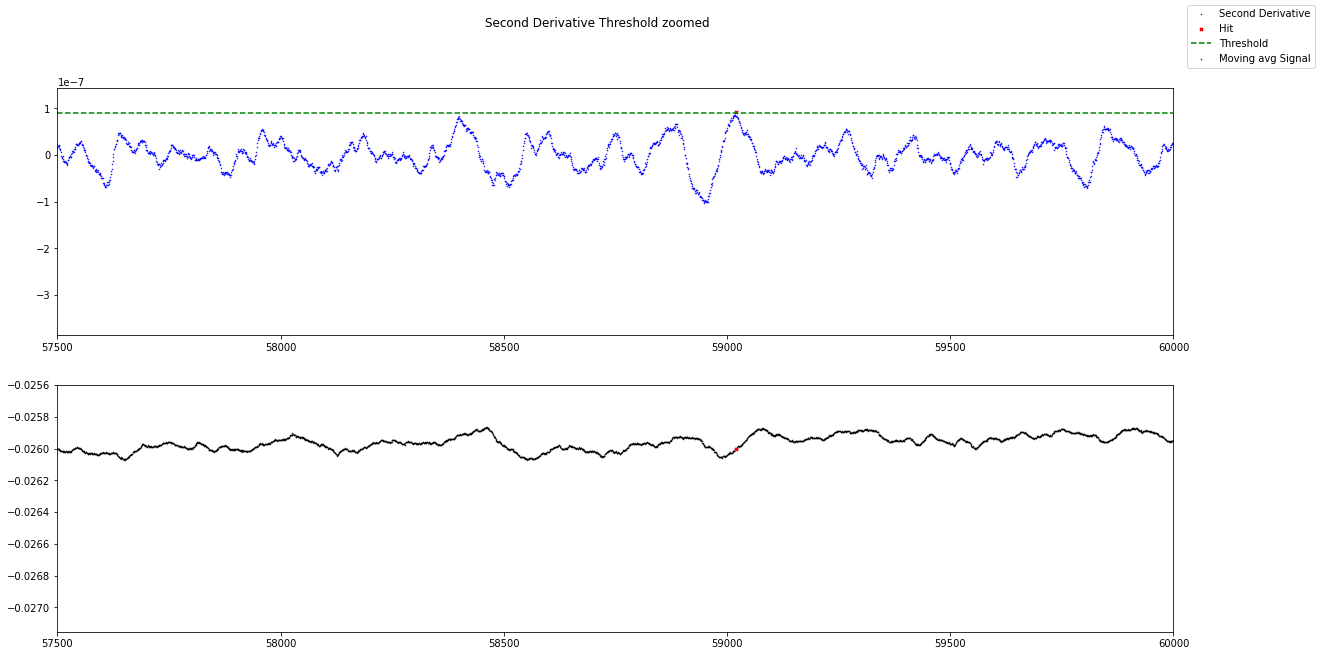

In [227]:
th = 0.9*1e-7
peaks, props = find_peaks(-sd, th)
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].scatter(np.linspace(0,len(sd),len(sd)),-sd,marker='.',color='blue',s=1, label='Second Derivative')
axs[1].scatter(np.linspace(0,len(moving_avg),len(moving_avg)), moving_avg, label='Moving avg Signal',marker='.',color='black',s=1)
axs[0].scatter(peaks, props['peak_heights'], marker='x', color='red', s=10, label='Hit')
axs[1].scatter(peaks, moving_avg[peaks], marker='x', color='red', s=10)
axs[0].axhline(th, 0, 1, linestyle='--', color='green', label='Threshold')
fig.suptitle('Second Derivative Threshold zoomed')
axs[0].set_xlim([5.75*1e4,6*1e4])
axs[1].set_xlim([5.75*1e4,6*1e4])
fig.legend()

In [216]:
with open('Trigger.txt','a') as file:
    file.writelines('\n'+str(peaks[0])+'\t'+str(props['peak_heights'][0]))